In [24]:
import re
import json

import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np

import seaborn as sns

# Data

In [2]:
with open("../data/dev.json") as json_file:
    data = json.load(json_file)

In [3]:
print(data[0]['data']['text'])

PETITIONER:
THE COMMISSIONER OF INCOME-TAXNEW DELHI

Vs.

RESPONDENT:
M/s. CHUNI LAL MOONGA RAM

DATE OF JUDGMENT:
05/05/1961

BENCH:
DAS, S.K.
BENCH:
DAS, S.K.
HIDAYATULLAH, M.
SHAH, J.C.

CITATION:            1962 SCR (2) 823
 1962 AIR 1272

ACT:
Excess Profits Tax-Income-Assesseecarrying on business in
taxable territory-Losses incurred in transactionsin non-
taxable territory-If allowable in computing income-Excess
Profits Tax Act, 1940 (15 of 1940), s. 5.

HEADNOTE:
During the assessment year 1946-47, the assessee was
carrying on speculative business in bullion at Delhi. It
entered into transactions in the nature of forward
transactions with parties at Bhatinda (in the Patiala State
outside the taxable territories of British India) in which
it suffered losses. The assessee claimed deduction of these
losses in the computation of its income.
Held, that the losses incurred in Bhatinda could not be
taken into account in computing the income of the assessee
in British India. Under the t

In [4]:
len(data)

30

In [5]:
doc = data[0]['data']['text']
used = doc[:doc.rindex("ACT:")]
doc = doc[doc.rindex("ACT:"):]
print(used)
print("-----------------------------")
print(doc)

PETITIONER:
THE COMMISSIONER OF INCOME-TAXNEW DELHI

Vs.

RESPONDENT:
M/s. CHUNI LAL MOONGA RAM

DATE OF JUDGMENT:
05/05/1961

BENCH:
DAS, S.K.
BENCH:
DAS, S.K.
HIDAYATULLAH, M.
SHAH, J.C.

CITATION:            1962 SCR (2) 823
 1962 AIR 1272


-----------------------------
ACT:
Excess Profits Tax-Income-Assesseecarrying on business in
taxable territory-Losses incurred in transactionsin non-
taxable territory-If allowable in computing income-Excess
Profits Tax Act, 1940 (15 of 1940), s. 5.

HEADNOTE:
During the assessment year 1946-47, the assessee was
carrying on speculative business in bullion at Delhi. It
entered into transactions in the nature of forward
transactions with parties at Bhatinda (in the Patiala State
outside the taxable territories of British India) in which
it suffered losses. The assessee claimed deduction of these
losses in the computation of its income.
Held, that the losses incurred in Bhatinda could not be
taken into account in computing the income of the assesse

In [6]:
# def extract_sentences(text, start_text):
#     pattern = re.compile(rf'\b{re.escape(start_text)}.*?[.!?](?=\s|$)', re.IGNORECASE | re.DOTALL)
#     matches = re.findall(pattern, text)
#     return matches

# # Example usage:
# # text_to_search = "This is a sample text. Starting sentence with given text. Another sentence with the given text. Not starting with it."

# start_text = "CITATION"
# result = extract_sentences(doc, start_text)

In [7]:
data[0].keys()

dict_keys(['id', 'annotations', 'data', 'meta'])

In [8]:
len(data[0]['annotations'])

1

In [9]:
data[0]['annotations'][0].keys()

dict_keys(['result'])

In [10]:
len(data[0]['annotations'][0]['result'])

96

# Tokenizing

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(tokenizer)

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


### Extract info from dictionary

In [12]:
sent_id = []
sent_start = []
sent_end = []
train_sents = []
target = []
for entry in data:
    _ids, _start, _end, _text, _labels = [], [], [], [], []
    # print(entry)
    # print(entry['annotations'][0]['result'])
    # for x , y in [(data_point['text'], data_point['labels']) for data_point in entry['annotations'][0]['result']['value']]:
    for data_point in entry['annotations'][0]['result']:
        _ids.append(data_point['id'])
        _start.append(data_point['value']['start'])
        _end.append(data_point['value']['end'])
        _text.append(data_point['value']['text'])
        _labels.append(data_point['value']['labels'])
    
    sent_id.append(_ids)
    sent_start.append(_start)
    sent_end.append(_end)
    train_sents.append(_text)
    target.append(_labels)

### Tokenize sentences and add CLS and SEP tokens

In [13]:
try:
    doc_lens = []
    for doc_index, doc in enumerate(train_sents):
        sent_lens = []
        for sent_index, sentence in enumerate(doc):
            train_sents[doc_index][sent_index] = [tokenizer.cls_token] + tokenizer.tokenize(sentence) + [tokenizer.sep_token]
            sent_lens.append(len(train_sents[doc_index][sent_index]))    
        doc_lens.append(sent_lens)
    
except TypeError:
    print("Sentences already tokenized. Check again")

In [14]:
print(f"Number of documents : {len(train_sents)}")

Number of documents : 30


In [15]:
df = pd.DataFrame()
df['lengths'] = doc_lens 
df['max_length'] = [np.max(i) for i in doc_lens]  

In [23]:
df.head()

,lengths,max_length
0,"[29, 19, 116, 40, 18, 30, 20, 55, 45, 33, 19, ...",311
1,"[10, 29, 49, 10, 79, 26, 23, 29, 32, 50, 24, 2...",176
2,"[16, 15, 10, 152, 40, 48, 51, 24, 51, 66, 18, ...",152
3,"[22, 10, 195, 47, 11, 31, 44, 22, 11, 37, 6, 5...",195
4,"[29, 18, 14, 6, 15, 24, 15, 18, 21, 8, 11, 11,...",152


In [17]:
df.iloc[0]

lengths       [29, 19, 116, 40, 18, 30, 20, 55, 45, 33, 19, ...
max_length                                                  311
Name: 0, dtype: object

329


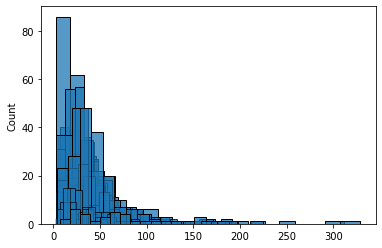

In [206]:
max_length = 0
for index, row in df.iterrows():
    sns.histplot(row['lengths'],bins=15)
    if row['max_length'] > max_length:
        max_length = row['max_length']
        
print(max_length)

### Padding the sentences with PAD token

In [18]:
# MAX_LENGTH = 330
# attention_matrix = np.zeros(train_sents)
for doc_index, doc in enumerate(train_sents):
    MAX_LENGTH = df.iloc[doc_index]['max_length'] + 1
    for sent_index, sentence in enumerate(doc):
        train_sents[doc_index][sent_index] = train_sents[doc_index][sent_index] + [tokenizer.pad_token for _ in range(MAX_LENGTH - len(train_sents[doc_index][sent_index]))]
        # for token in train_sents[doc_index][sent_index]:
        # attention_matrix[doc_index][sent_index] = [1 if token != tokenizer.pad_token else 0 for token in train_sents[doc_index][sent_index]]

### Creating attention matrix for each document

In [63]:
ids = []
segs = []
for doc_index, doc in enumerate(train_sents):
    globals()[f"attention_mask_{doc_index}"] = np.zeros_like(doc,dtype='int')
    sent_id = []
    sent_segs = []
    for sent_index,sentence in enumerate(doc):
        sent_id.append(tokenizer.convert_tokens_to_ids(sentence))
        sent_segs.append([0 for _ in range(len(sentence))])
        for i in range(len(sentence)):
            if sentence[i] != tokenizer.pad_token:
                globals()[f'attention_mask_{doc_index}'][sent_index][i] = 1 
    ids.append(sent_id)
    segs.append(sent_segs)

In [64]:
len(ids)
# len(segs)

30

In [65]:
for i in range(len(train_sents)):
    print(f'Attention Mask for document {i+1} : {globals()[f"attention_mask_{i}"].shape}')

Attention Mask for document 1 : (96, 312)
Attention Mask for document 2 : (139, 177)
Attention Mask for document 3 : (150, 153)
Attention Mask for document 4 : (54, 196)
Attention Mask for document 5 : (86, 153)
Attention Mask for document 6 : (57, 139)
Attention Mask for document 7 : (68, 169)
Attention Mask for document 8 : (113, 112)
Attention Mask for document 9 : (199, 228)
Attention Mask for document 10 : (139, 138)
Attention Mask for document 11 : (76, 140)
Attention Mask for document 12 : (104, 115)
Attention Mask for document 13 : (209, 155)
Attention Mask for document 14 : (135, 106)
Attention Mask for document 15 : (64, 193)
Attention Mask for document 16 : (62, 330)
Attention Mask for document 17 : (98, 177)
Attention Mask for document 18 : (111, 199)
Attention Mask for document 19 : (62, 226)
Attention Mask for document 20 : (130, 260)
Attention Mask for document 21 : (46, 177)
Attention Mask for document 22 : (66, 198)
Attention Mask for document 23 : (77, 97)
Attention M

# Extracting sentence embeddings

In [26]:
model = BertModel.from_pretrained("bert-base-uncased")

model.safetensors: 100%|██████████| 440M/440M [01:18<00:00, 5.58MB/s] 


In [66]:
for i in range(len(train_sents)):
    globals()[f'ids_tensor_{i}'] = torch.Tensor(ids[i]).unsqueeze(0)
    globals()[f'attention_mask_{i}'] = torch.from_numpy(globals()[f'attention_mask_{i}']).unsqueeze(0)
    globals()[f'seg_tokens_{i}'] = torch.Tensor(segs[i]).unsqueeze(0)

In [68]:
attention_mask_0.size()

torch.Size([1, 96, 312])

In [69]:
ids_tensor_0.size()

torch.Size([1, 96, 312])

In [70]:
for doc_index in range(len(train_sents)):
    output = model(globals()[f'ids_tensor_{doc_index}'],
                    attention_mask = globals()[f'attention_mask_{doc_index}'],
                    token_type_ids = globals()[f'seg_tokens_{doc_index}'])
    globals()[f'last_hidden_state_{doc_index}'], globals()[f'pooler_output_{doc_index}'] = output[0], output[1]
    

ValueError: too many values to unpack (expected 2)